In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### ImageNet Dataset

#### Local ImageNet Dataset

Download the dataset

```
wget https://pjreddie.com/media/files/imagenet64.tar
```

Extract the dataset to

```
./dataset/imagenet64/
```


In [2]:
import os

datasets = './dataset/imagenet64'
checkpoints = './checkpoints/imagenet64/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [3]:
!ls checkpoints/imagenet64/

In [4]:
def get_imagenet64_data():
    # Data augmentation transformations. Not for Testing!
    transform_train = transforms.Compose([
        transforms.Resize(64),  # Takes images smaller than 64 and enlarges them
        transforms.RandomCrop(64, padding=4, padding_mode='edge'),  # Take 64x64 crops from 72x72 padded images
        transforms.RandomHorizontalFlip(),  # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root=datasets + '/train/', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root=datasets + '/val/', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    return {'train': trainloader, 'test': testloader}


data = get_imagenet64_data()

#### Visualizing ImageNet Data

torch.Size([8, 3, 64, 64])


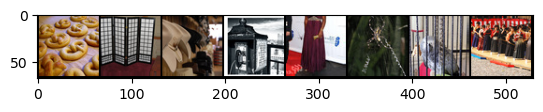

Labels:tensor(932) tensor(789) tensor(515) tensor(707) tensor(578) tensor(815) tensor(87) tensor(456)
torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])


In [5]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

# ResNet50 Model

In [6]:
class ResNet50(nn.Module):
    def __init__(self, block, num_classes=1000):
        super(ResNet50, self).__init__()
        self.block = block
        self.num_classes = num_classes

        self.stage1 = self.stage_input()
        self.stage2 = self.stage_blocks(3, 64, 64, stride=1)
        self.stage3 = self.stage_blocks(4, 64 * 4, 128, stride=2)
        self.stage4 = self.stage_blocks(6, 128 * 4, 256, stride=2)
        self.stage5 = self.stage_blocks(3, 256 * 4, 512, stride=2)
        self.stage6 = self.stage_output(512 * 4, self.num_classes)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        return x

    def stage_input(self):
        conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        bn = nn.BatchNorm2d(64)
        relu = nn.ReLU()
        pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        return nn.Sequential(conv, bn, relu, pool)

    def stage_blocks(self, n, in_channels, out_channels, stride=1):
        layers = [self.block(in_channels, out_channels, stride)]
        for i in range(n - 1):
            layers.append(self.block(out_channels * 4, out_channels))
        return nn.Sequential(*layers)

    def stage_output(self, in_channels, out_channels, stride=1):
        pool = nn.AdaptiveAvgPool2d((1, 1))
        flatten = nn.Flatten()
        fc = nn.Linear(in_channels, out_channels)
        return nn.Sequential(pool, flatten, fc)


class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU()

        self.need_downsample = stride != 1 or in_channels != out_channels * 4
        if self.need_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.need_downsample:
            identity = self.downsample(identity)

        out = x + identity
        out = self.relu(out)

        return out

# SEnet

In [13]:
class SEBlock(nn.Module):
    def __init__(self, channel, r):
        super().__init__()
        reductionChannel = int(channel / r)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(channel, reductionChannel)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(reductionChannel, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # pdb.set_trace()
        out = self.pool(x)
        batch, channel = out.size(0), out.size(1)
        out = out.view(batch, -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = out.view(batch, channel, 1, 1)
        out = self.sigmoid(out)
        return out


class SEResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SEResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU()

        self.need_downsample = stride != 1 or in_channels != out_channels * 4
        if self.need_downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4)
            )
        else:
            self.downsample = None

        self.seBlock = SEBlock(out_channels * 4, 1)

    def forward(self, x):
        identity = x

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        if self.need_downsample:
            identity = self.downsample(identity)

        #apply SE
        scale = self.seBlock(x)

        out = x * scale + identity
        out = self.relu(out)

        return out

### Training

The training function is similar to past versions with some updates. In particular, now there is a `schedule` parameter to handle learning rate scheduling and also a `checkpoint_path` parameter which will be where training checkpoints are saved (if provided).

The core of training is the same though, get a batch, run the model forward, calculate loss, run it backward, update.

In [9]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005,
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print("Learning rate: %f" % schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print("Learning rate: %f" % schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step()  # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every - 1:  # print every 10 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch + 1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-resnet50-%d.pkl' % (epoch + 1))
    return losses


def accuracy(net, dataloader):
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


def smooth(x, size):
    return np.convolve(x, np.ones(size) / size, mode='valid')

#### Training From Scratch

To start off training we can just create a model and invoke our training command. **Note** this will take a while, maybe overnight, to finish training!

In this case we are training with a learning rate schedule:
- The first 5 epochs at 0.1
- Then 10 epochs at 0.01
- Then 5 more at 0.001

I just sort of made the schedule up so you can try different things if you want!

In [14]:
net = ResNet50(SEResNetBlock)
losses = train(net, data['train'], epochs=20, schedule={0: .1, 5: .01, 15: .001}, checkpoint_path=checkpoints)

Learning rate: 0.100000
[0,    10] loss: 7.594
[0,    20] loss: 7.477
[0,    30] loss: 7.045
[0,    40] loss: 6.994
[0,    50] loss: 6.965
[0,    60] loss: 6.960
[0,    70] loss: 6.926
[0,    80] loss: 6.915
[0,    90] loss: 6.924
[0,   100] loss: 6.914
[0,   110] loss: 6.908
[0,   120] loss: 6.912
[0,   130] loss: 6.908
[0,   140] loss: 6.910
[0,   150] loss: 6.907
[0,   160] loss: 6.910
[0,   170] loss: 6.912


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x114766dd0>
Traceback (most recent call last):
  File "/Users/limuhan/Public/ProgrammingEnvironment/Python/Anaconda3/envs/torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/limuhan/Public/ProgrammingEnvironment/Python/Anaconda3/envs/torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/limuhan/Public/ProgrammingEnvironment/Python/Anaconda3/envs/torch/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/limuhan/Public/ProgrammingEnvironment/Python/Anaconda3/envs/torch/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/limuhan/Public/ProgrammingEnvironment/Python/Anaconda3/envs/torch/lib/pytho

KeyboardInterrupt: 

#### Continuing Training From A Checkpoint

We can also restart training from a checkpoint if necessary. Colab can go down or training can get interrupted so this is handy. If you have already started training you can use any checkpoint you have, or you can download one from me!

In [ ]:
# Restart training!
net = ResNet50(ResNetBlock)
state = torch.load(checkpoints + 'checkpoint-19.pkl')
losses2 = train(net, data['train'], epochs=20, schedule={0: .1, 5: .01, 15: .001}, checkpoint_path=checkpoints,
               state=state)

Learning rate: 0.100000
Learning rate: 0.010000
Learning rate: 0.001000
[20,    10] loss: 3.439
[20,    20] loss: 3.291
[20,    30] loss: 3.198
[20,    40] loss: 3.281
[20,    50] loss: 3.223
[20,    60] loss: 3.365
[20,    70] loss: 3.206
[20,    80] loss: 3.278
[20,    90] loss: 3.302
[20,   100] loss: 3.272
[20,   110] loss: 3.338
[20,   120] loss: 3.310
[20,   130] loss: 3.315
[20,   140] loss: 3.255
[20,   150] loss: 3.319
[20,   160] loss: 3.276
[20,   170] loss: 3.313
[20,   180] loss: 3.281
[20,   190] loss: 3.260
[20,   200] loss: 3.423
[20,   210] loss: 3.267
[20,   220] loss: 3.226
[20,   230] loss: 3.326
[20,   240] loss: 3.426
[20,   250] loss: 3.181
[20,   260] loss: 3.167
[20,   270] loss: 3.357
[20,   280] loss: 3.322
[20,   290] loss: 3.229
[20,   300] loss: 3.158
[20,   310] loss: 3.368
[20,   320] loss: 3.310
[20,   330] loss: 3.209
[20,   340] loss: 3.289
[20,   350] loss: 3.364
[20,   360] loss: 3.240
[20,   370] loss: 3.405
[20,   380] loss: 3.319
[20,   390] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34665 had too many entries: 4, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  % (tag, len(values))


[20,   680] loss: 3.326
[20,   690] loss: 3.255
[20,   700] loss: 3.330
[20,   710] loss: 3.263
[20,   720] loss: 3.317
[20,   730] loss: 3.228
[20,   740] loss: 3.351
[20,   750] loss: 3.384
[20,   760] loss: 3.509
[20,   770] loss: 3.288
[20,   780] loss: 3.231
[20,   790] loss: 3.308
[20,   800] loss: 3.326
[20,   810] loss: 3.324
[20,   820] loss: 3.254
[20,   830] loss: 3.300
[20,   840] loss: 3.344
[20,   850] loss: 3.283
[20,   860] loss: 3.256
[20,   870] loss: 3.238
[20,   880] loss: 3.296
[20,   890] loss: 3.300
[20,   900] loss: 3.215
[20,   910] loss: 3.250
[20,   920] loss: 3.264
[20,   930] loss: 3.314
[20,   940] loss: 3.267
[20,   950] loss: 3.183
[20,   960] loss: 3.331
[20,   970] loss: 3.230
[20,   980] loss: 3.302
[20,   990] loss: 3.347
[20,  1000] loss: 3.391
[20,  1010] loss: 3.267
[20,  1020] loss: 3.245
[20,  1030] loss: 3.340
[20,  1040] loss: 3.404
[20,  1050] loss: 3.202
[20,  1060] loss: 3.278
[20,  1070] loss: 3.296
[20,  1080] loss: 3.321
[20,  1090] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[20,  1670] loss: 3.259
[20,  1680] loss: 3.328
[20,  1690] loss: 3.278
[20,  1700] loss: 3.366
[20,  1710] loss: 3.369
[20,  1720] loss: 3.380
[20,  1730] loss: 3.372
[20,  1740] loss: 3.220
[20,  1750] loss: 3.519
[20,  1760] loss: 3.328
[20,  1770] loss: 3.262
[20,  1780] loss: 3.279
[20,  1790] loss: 3.305
[20,  1800] loss: 3.375
[20,  1810] loss: 3.258
[20,  1820] loss: 3.297
[20,  1830] loss: 3.342
[20,  1840] loss: 3.255
[20,  1850] loss: 3.323
[20,  1860] loss: 3.270
[20,  1870] loss: 3.194
[20,  1880] loss: 3.343
[20,  1890] loss: 3.293
[20,  1900] loss: 3.264
[20,  1910] loss: 3.283
[20,  1920] loss: 3.263
[20,  1930] loss: 3.364
[20,  1940] loss: 3.376
[20,  1950] loss: 3.258
[20,  1960] loss: 3.365
[20,  1970] loss: 3.245
[20,  1980] loss: 3.225
[20,  1990] loss: 3.149
[20,  2000] loss: 3.311
[20,  2010] loss: 3.374
[20,  2020] loss: 3.293
[20,  2030] loss: 3.356
[20,  2040] loss: 3.270
[20,  2050] loss: 3.306
[20,  2060] loss: 3.335
[20,  2070] loss: 3.225
[20,  2080] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 947. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


[20,  4490] loss: 3.311
[20,  4500] loss: 3.353
[20,  4510] loss: 3.244
[20,  4520] loss: 3.327
[20,  4530] loss: 3.417
[20,  4540] loss: 3.351
[20,  4550] loss: 3.278
[20,  4560] loss: 3.349
[20,  4570] loss: 3.286
[20,  4580] loss: 3.277
[20,  4590] loss: 3.343
[20,  4600] loss: 3.317
[20,  4610] loss: 3.308
[20,  4620] loss: 3.328
[20,  4630] loss: 3.276
[20,  4640] loss: 3.341
[20,  4650] loss: 3.412
[20,  4660] loss: 3.380
[20,  4670] loss: 3.401
[20,  4680] loss: 3.328


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[20,  4690] loss: 3.279
[20,  4700] loss: 3.253
[20,  4710] loss: 3.328
[20,  4720] loss: 3.272
[20,  4730] loss: 3.257
[20,  4740] loss: 3.323
[20,  4750] loss: 3.318
[20,  4760] loss: 3.340
[20,  4770] loss: 3.288
[20,  4780] loss: 3.178
[20,  4790] loss: 3.156
[20,  4800] loss: 3.357
[20,  4810] loss: 3.289
[20,  4820] loss: 3.376
[20,  4830] loss: 3.373
[20,  4840] loss: 3.373
[20,  4850] loss: 3.354
[20,  4860] loss: 3.251
[20,  4870] loss: 3.290
[20,  4880] loss: 3.354
[20,  4890] loss: 3.267
[20,  4900] loss: 3.415
[20,  4910] loss: 3.324
[20,  4920] loss: 3.421
[20,  4930] loss: 3.338
[20,  4940] loss: 3.337
[20,  4950] loss: 3.286
[20,  4960] loss: 3.261
[20,  4970] loss: 3.357
[20,  4980] loss: 3.232
[20,  4990] loss: 3.351
[20,  5000] loss: 3.279
[20,  5010] loss: 3.354
[20,  5020] loss: 3.371
[20,  5030] loss: 3.285
[20,  5040] loss: 3.234
[20,  5050] loss: 3.428
[20,  5060] loss: 3.387
[20,  5070] loss: 3.316
[20,  5080] loss: 3.199
[20,  5090] loss: 3.284
[20,  5100] loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 34665 had too many entries: 4, expected 1
  % (tag, len(values))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:590: UserWarning: Metadata Warning, tag 296 had too many entries: 4, expected 1
  % (tag, len(values))


[20,  7980] loss: 3.314
[20,  7990] loss: 3.243
[20,  8000] loss: 3.417
[20,  8010] loss: 3.244
[20,  8020] loss: 3.440
[20,  8030] loss: 3.276
[20,  8040] loss: 3.409
[20,  8050] loss: 3.394
[20,  8060] loss: 3.361
[20,  8070] loss: 3.344
[20,  8080] loss: 3.249
[20,  8090] loss: 3.255
[20,  8100] loss: 3.417
[20,  8110] loss: 3.253
[20,  8120] loss: 3.300
[20,  8130] loss: 3.359
[20,  8140] loss: 3.231
[20,  8150] loss: 3.284
[20,  8160] loss: 3.337
[20,  8170] loss: 3.376
[20,  8180] loss: 3.268
[20,  8190] loss: 3.239
[20,  8200] loss: 3.318
[20,  8210] loss: 3.288
[20,  8220] loss: 3.293
[20,  8230] loss: 3.339
[20,  8240] loss: 3.307
[20,  8250] loss: 3.305
[20,  8260] loss: 3.235
[20,  8270] loss: 3.396
[20,  8280] loss: 3.358
[20,  8290] loss: 3.255
[20,  8300] loss: 3.216
[20,  8310] loss: 3.319
[20,  8320] loss: 3.258
[20,  8330] loss: 3.230
[20,  8340] loss: 3.236
[20,  8350] loss: 3.234
[20,  8360] loss: 3.345
[20,  8370] loss: 3.249
[20,  8380] loss: 3.314
[20,  8390] loss

### Testing The Trained Model

Our model gets almost 30% accuracy. The loss curve looks very standard for these types of models, we see the quick drop, the leveling off, and then subsequent drops when we lower the learning rate.

Testing  accuracy: 0.289700


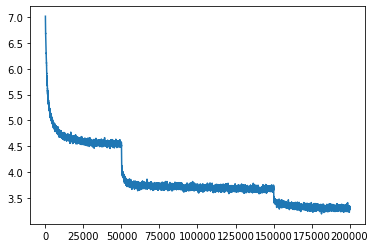

In [ ]:
plt.plot(smooth(losses, 50))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

### Testing From A Checkpoint

We can also test versions of the model from when we took the checkpoint every epoch.

Testing  accuracy: 0.207440


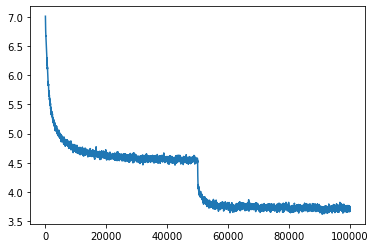

In [ ]:
# Test previous checkpoints
net = ResNet50(ResNetBlock)
state = torch.load(checkpoints + "checkpoint-10.pkl")
net.load_state_dict(state["net"])
plt.plot(smooth(state["losses"], 50))
print("Testing  accuracy: %f" % accuracy(net, data["test"]))

## TODO: Impl SE-ResNet

In [ ]:
class SEBlock(nn.Module):
    pass